# Code for plotting all results and all statistical tests.
This was supposed to be "the pretty" notebook.

Do not run this unless you have all my pickles! The results are already printed and displayed.

For pickle requests, email `annaproxy@protonmail.com`.

In [13]:
import pickle
import torch
import numpy as np
from StructuralProbe import StructuralProbe
from POSProbe import POSProbe
from collections import defaultdict
from tree_utils import calc_uuas
%load_ext autoreload
%autoreload 2

with open("FINALS.pickle", "rb") as f:
    result_dict = pickle.load(f)
    
with open("XLguysDEPLR5.pickle", "rb") as f:
    lowlr_dict = pickle.load(f)
    
with open("XLBoysPOSLR5More.pickle", "rb") as f:
    lowlr_dict2 = pickle.load(f)
    lowlr_dict['pos'] = lowlr_dict2['pos']
    lowlr_dict['controlpos'] = lowlr_dict2['controlpos']  
    
with open("Shuffled_XL.pickle", "rb") as f:
    shuffled_dict = pickle.load(f)
    
with open("Shuffled_lstm_gpt.pickle", "rb") as f:
    new_dict = pickle.load(f)
    shuffled_dict['pos']['lstm'] = new_dict['pos']['lstm']
    shuffled_dict['pos']['transformer'] = new_dict['pos']['transformer']    
    
with open("Shuffled_XL2.pickle", "rb") as f:
    new_dict = pickle.load(f)
    for model in ['lstm','transformer','XLNet','TransformerXL']:
        if 30 in shuffled_dict['pos'][model][256][0.2]:
            raise ValueError("Adding to dictionary that exists! Do not!")
        shuffled_dict['pos'][model][256][0.2][30] = new_dict['pos'][model][256][0.2][30]
        shuffled_dict['pos'][model][256][0][30] = new_dict['pos'][model][256][0][30]        

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
from tree_utils import create_or_load_structural_data
import torch.utils.data as data
import math

from datasets import * 
device = 'cuda:0'
def mean_test_acc(the_dict):
    """Averages uuas score or accuracy on test set over three seeds"""
    three_accs = [the_dict[z]['test_acc'] for z in the_dict]
    return np.mean(three_accs), np.std(three_accs), three_accs

def mean_dev_acc(the_dict):
    """Averages uuas score or accuracy on dev set over three seeds"""
    three_accs = [the_dict[z]['dev_acc'] for z in the_dict]
    return np.mean(three_accs), np.std(three_accs)

def uuas_per_length(model, test_loader):
    """Calculates uuas per length for length plots"""
    length_amount_dict = defaultdict(lambda:0)
    length_uuas_dict = defaultdict(lambda:0)
    result = dict()
    model.eval()
    with torch.no_grad():
        for distances, embs, lengths in test_loader:
            embs = embs.to(device)
            distances = distances.to(device)
            lengths = lengths.to(device)

            embs = embs.to(device)
            distances = distances.to(device)
            lengths = lengths.to(device)
            outputs = model(embs)
            l = lengths[0].item()
            preds = outputs[0,0:l, 0:l]
            gold = distances[0,0:l, 0:l]

            u = calc_uuas(preds, gold)
            if not math.isnan(u):
                length_amount_dict[l] +=1
                length_uuas_dict[l] += u
    result2 = {}
    for k in sorted(list(length_uuas_dict.keys())):
        result[k] = length_uuas_dict[k]/length_amount_dict[k]
        result2[k] = result[k] / k
    return result, length_amount_dict


def uuas_length_averaged_per_seed(model, test_loader):
    """
    Collects uuas score per sentence length in a dict and averaged over three seeds
    Also returns list of all seeds, since we're now doing significance testing
    """
    result = defaultdict(lambda:0)
    result2 = defaultdict(lambda:0)
    fullboys =defaultdict(lambda:[])
    seeds = 0
    for seed in model:
        seeds +=1
        specific_results, specific_results2 = uuas_per_length(model[seed]['state_dict'], test_loader)
        for k in specific_results:
            result[k] += specific_results[k]
            fullboys[k].append(specific_results[k])
            
        for k in specific_results2:
            result2[k] += specific_results2[k]
    for k in result:
        result[k] /= seeds
        result2[k] /= seeds
    return result, result2, fullboys

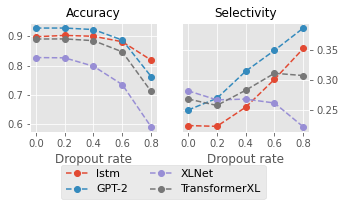

In [109]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(5,2))

ANALYZE_DROPOUT = True
h_list = [256]
d_list = [0,0.2,0.4,0.6,0.8]
for model in ['lstm', 'transformer', 'LRXLNet', 'TransformerXL']:#, 'LRXLNet', 'LRTransformerXL']:
    if 'LR' not in model:
        the_dict = result_dict
        lr = False
    else:
        the_dict = lowlr_dict
        model = model[2:]
        lr = True
        
    for h in h_list:
        x_axis = []
        y_axis = []
        y_axis_control = []
        y_axis_select = []
        for d in d_list:
            # Mean for POS task
            mean = mean_test_acc(the_dict['pos'][model][h][d])
            
            # Mean for Control task
            mean_control = mean_test_acc(the_dict['controlpos'][model][h][d])
            #print(model, mean, mean_control)
            # Append
            x_axis.append(d)
            y_axis.append(mean[0])
            y_axis_select.append(mean[0] - mean_control[0])
        #print(x_axis, y_axis, y_axis_select)
        model_name = (model if model != 'transformer' else 'GPT-2')
        #model_name = model_name if not lr else model_name +'lr'
        ax1.plot(x_axis, y_axis, '--o', label=model_name, )
        ax2.plot(x_axis, y_axis_select, '--o', label=model_name,)
        z = ax2.legend(fontsize=11, bbox_to_anchor=(0.7,-0.25), ncol=2)
        #ax1.set_ylim(0.3,0.8)
        #ax2.set_ylim(0.1,0.25)
ax1.set_xticks([0,0.2,0.4,0.6,0.8])
ax2.set_xticks([0,0.2,0.4,0.6,0.8])
ax1.set_title("Accuracy", fontsize=12)
ax2.set_title("Selectivity", fontsize=12)
ax2.yaxis.tick_right()
ax1.set_xlabel("Dropout rate", fontsize=12)
ax2.set_xlabel("Dropout rate", fontsize=12)
#plt.savefig('pos_select.eps', format='eps',  dpi=1200,  bbox_extra_artists=(z,), bbox_inches='tight')
#plt.tight_layout()
plt.show()


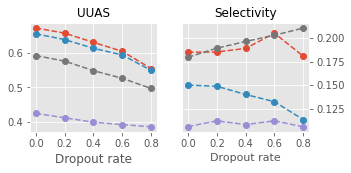

In [110]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(5,2))


for model in ['lstm', 'transformer', 'XLNet', 'TransformerXL']:
    if 'LR' not in model:
        the_dict = result_dict
        lr = False
    else:
        the_dict = lowlr_dict
        model = model[2:]
        lr = True
        
    if ANALYZE_DROPOUT:
        d_list = [0,0.2,0.4,0.6,0.8]
        h_list = [64]
    else:
        d_list = [0]
        h_list = [16,64,128]
        
    for h in h_list:
        x_axis = []
        y_axis = []
        y_axis_control = []
        y_axis_select = []
        for d in d_list :
            # Mean for POS task
            mean = mean_test_acc(the_dict['dep'][model][h][d])
            
            # Mean for Control task
            mean_control = mean_test_acc(the_dict['controldep'][model][h][d])
            #print(model, mean, mean_control)
            # Append
            x_axis.append(d)
            y_axis.append(mean[0])
            y_axis_select.append(mean[0] - mean_control[0])
            
        model_name = (model if model != 'transformer' else 'GPT-2')
        model_name = model_name if not lr else model_name +'lr'
        ax1.plot(x_axis, y_axis, '--o', label=model_name, )
        ax2.plot(x_axis, y_axis_select, '--o', label=model_name,)
        #ax2.legend(fontsize=16, bbox_to_anchor=(1,1))
        #ax1.set_ylim(0.3,0.8)
        #ax2.set_ylim(0.1,0.25)
#ax2.legend(fontsize=12, bbox_to_anchor=(1,1))   
ax1.set_title("UUAS", fontsize=12)
ax2.set_title("Selectivity", fontsize=12)
ax2.yaxis.tick_right()
ax1.set_xticks([0,0.2,0.4,0.6,0.8])
ax2.set_xticks([0,0.2,0.4,0.6,0.8])
ax1.set_xlabel("Dropout rate", fontsize=12)
ax2.set_xlabel("Dropout rate", fontsize=11)
#plt.savefig('dep_select.eps', format='eps',  dpi=1200, bbox_inches='tight')
plt.show()


In [95]:
gpt2embs = create_or_load_structural_data("test", None, None, extra_transformer='GPT2')
lstmembs = create_or_load_structural_data("test", None, None, extra_transformer='RNN')
xlnetembs = create_or_load_structural_data("test", None, None, extra_transformer='XLNet')
transformerxlembs = create_or_load_structural_data("test", None, None, extra_transformer='TransformerXL')

test_loader_gpt2 = data.DataLoader(StructuralDataset(*gpt2embs), batch_size=1, shuffle=False)
test_loader_lstm = data.DataLoader(StructuralDataset(*lstmembs), batch_size=1, shuffle=False)
test_loader_xlnet = data.DataLoader(StructuralDataset(*xlnetembs), batch_size=1, shuffle=False)
test_loader_transformerxl = data.DataLoader(StructuralDataset(*transformerxlembs), batch_size=1, shuffle=False)

USING SAVE FILE corpus/transformer_structuraltest.pickle
USING SAVE FILE corpus/RNN_structuraltest.pickle
USING SAVE FILE corpus/transformer_structuraltest_XLNet.pickle
USING SAVE FILE corpus/transformer_structuraltest_TransformerXL.pickle


In [96]:
# 64,0 are best hyperparams for each
lrxlnet, _, fullxl = uuas_length_averaged_per_seed(lowlr_dict['dep']['XLNet'][128][0.8], test_loader_xlnet)
lrtransformerxl, _ , fulltxl = uuas_length_averaged_per_seed(lowlr_dict['dep']['XLNet'][128][0], test_loader_transformerxl)

gpt2, ngpt2, fullgpt  = uuas_length_averaged_per_seed(result_dict['dep']['transformer'][64][0], test_loader_gpt2)
rnn, nrnn, fulllstm = uuas_length_averaged_per_seed(result_dict['dep']['lstm'][64][0], test_loader_lstm)
xlnet, nxlnet , fullxl = uuas_length_averaged_per_seed(result_dict['dep']['XLNet'][64][0], test_loader_xlnet)
txl, ntxl, fulltxl = uuas_length_averaged_per_seed(result_dict['dep']['TransformerXL'][64][0], test_loader_transformerxl)

/home/anna/Documents/uni/nlp2/nlp2-probing-lms/tree_utils.py:125: RuntimeWarning: invalid value encountered in double_scalars
  uuas = np.sum([pred_edge in gold_edges for pred_edge in pred_edges]) / len(gold_edges)


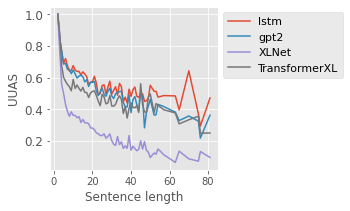

In [112]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig, ax1 = plt.subplots(1,1, figsize=(3,3))

ax1.plot(*zip(*rnn.items()), label='lstm')
ax1.plot(*zip(*gpt2.items()), label='gpt2')
ax1.plot(*zip(*xlnet.items()), label='XLNet')
ax1.plot(*zip(*txl.items()), label='TransformerXL')

ax1.tick_params(axis='y', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)

z=ax1.legend(fontsize=11,bbox_to_anchor=(1,1))
ax1.set_xlabel("Sentence length",fontsize=12)
ax1.set_ylabel("UUAS", fontsize=12)
#plt.savefig('lengths.eps', format='eps',  dpi=1200,  bbox_extra_artists=(z,), bbox_inches='tight')
plt.show()

In [116]:
def get_slope(modeldict):
    xs1 = np.array(list(modeldict.keys()))
    ys1 = np.array(list(modeldict.values()))
    xs = np.array(list(modeldict.keys())[6:30])
    ys = np.array(list(modeldict.values())[6:30])
    return scipy.stats.linregress(xs, ys).slope, scipy.stats.linregress(xs1, ys1).slope

def decrease(modeldict):
    avg_acc1 = 0
    avg_acc2 = 0
    range1 = range(6,16)
    range2 = range(16,30)
    total_len = 0
    for i in range1 :
        avg_acc1 += modeldict[i] * nrnn[i]
        total_len += nrnn[i]
        
    total_len2 = 0
    for i in range2:
        avg_acc2 += modeldict[i] * nrnn[i] 
        total_len2 += nrnn[i]
    
    avg1 = avg_acc1/total_len
    avg2 = avg_acc2/total_len2
    #print('Percentage of short sentences', total_len/(total_len+total_len2))
    #print('Short',round(avg1,3),'Long', round(avg2,3))
    #print("Ratio", round(avg2/avg1,3))
    return avg2/avg1

print("===Average Slopes and Ratios per model====")
print('gpt2', get_slope(gpt2), decrease(gpt2))
print('rnn', get_slope(rnn),decrease(rnn))
print('xlnet', get_slope(xlnet),decrease(xlnet))
print('lrxlnet', get_slope(lrxlnet),decrease(lrxlnet))
print('transformerxl', get_slope(txl),decrease(txl))
print('lrtransformerxl', get_slope(lrtransformerxl), decrease(lrtransformerxl))
print()
    
    
print("===Significance test per model combination===")
lstmdic = {'slope':[],'dec':[]}
for i in range(3):
    one_dict = {z:fulllstm[z][i] for z in fulllstm.keys()}
    slope = get_slope(one_dict)
    dec = decrease(one_dict)
    lstmdic['slope'].append(slope)
    lstmdic['dec'].append(dec)    
    
gptdic = {'slope':[],'dec':[]}
for i in range(3):
    one_dict = {z:fullgpt[z][i] for z in fulllstm.keys()}
    slope = get_slope(one_dict)
    dec = decrease(one_dict)
    gptdic['slope'].append(slope)
    gptdic['dec'].append(dec)   
    
xlnetdic = {'slope':[],'dec':[]}
for i in range(3):
    one_dict = {z:fullxl[z][i] for z in fulllstm.keys()}
    slope = get_slope(one_dict)
    dec = decrease(one_dict)
    xlnetdic['slope'].append(slope)
    xlnetdic['dec'].append(dec)   
    
txldic = {'slope':[],'dec':[]}
for i in range(3):
    one_dict = {z:fulltxl[z][i] for z in fulllstm.keys()}
    slope = get_slope(one_dict)
    dec = decrease(one_dict)
    txldic['slope'].append(slope)
    txldic['dec'].append(dec)   
    
tempdicprint = ["lstm","gpt","xlnet","txl"]
for c1, combo in enumerate([lstmdic, gptdic,xlnetdic,txldic]):
    for c2, combo2 in enumerate([lstmdic, gptdic,xlnetdic,txldic]):
        if c2 > c1:
            print(tempdicprint[c1], "versus", tempdicprint[c2])
            print("Slope t-test", stats.ttest_ind(combo['slope'], combo2['slope'], equal_var=False).pvalue)
            print("Ratio t-test", stats.ttest_ind(combo['dec'], combo2['dec'], equal_var=False).pvalue)
            print()
    

===Average Slopes and Ratios per model====
gpt2 (-0.007423864160867182, -0.005858406052909515) 0.8523276587146883
rnn (-0.006861204882335812, -0.0042293759379003395) 0.8607917295862645
xlnet (-0.008020740040098834, -0.0062282984010580645) 0.7389254897922413
lrxlnet (-0.007147022086868125, -0.005965199950547145) 0.733557508304367
transformerxl (-0.0054010402798957595, -0.0045729605909952025) 0.8858555405795786
lrtransformerxl (-0.005278384415699227, -0.00463079219486197) 0.8140910610268606

===Significance test per model combination===
lstm versus gpt
Slope t-test [8.48564118e-02 3.85236987e-05]
Ratio t-test 0.13188743706632552

lstm versus xlnet
Slope t-test [0.08156498 0.00014494]
Ratio t-test 0.008138375653408575

lstm versus txl
Slope t-test [0.00114669 0.00941643]
Ratio t-test 0.004998513613199417

gpt versus xlnet
Slope t-test [0.24805087 0.03520588]
Ratio t-test 0.006514529177211573

gpt versus txl
Slope t-test [1.88985458e-03 1.73464897e-05]
Ratio t-test 0.002412185970107072

xl

lstm pos 256 0.2 0.9026670917012006 0.22169535649771532
gpt2 pos 256 0.2 0.9277574115396877 0.2687413664860271
XLNet pos 256 0 0.816836680480289 0.25978907661247475
TransformerXL pos 256 0.2 0.8907926894060143 0.2568271172032728
LRXLNet pos 256 0 0.8273031558814153 0.28143927319094675
LRTransformerXL pos 256 0.2 0.8863165444692381 0.31829773669110617
lstm dep 64 0 0.6717540982852755 0.18495937536094836
gpt2 dep 64 0 0.6549281926743292 0.1501442359853704
XLNet dep 64 0 0.4253525171973796 0.10604952522209848
TransformerXL dep 64 0 0.5920818066988821 0.17967980331411065
LRXLNet dep 64 0 0.40919218179748007 0.12676957585332482
LRTransformerXL dep 64 0 0.5422582578011736 0.1990853033619842


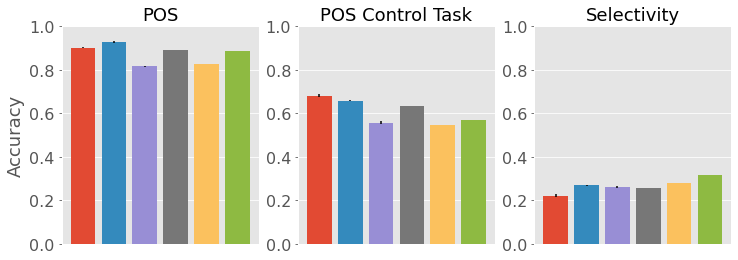

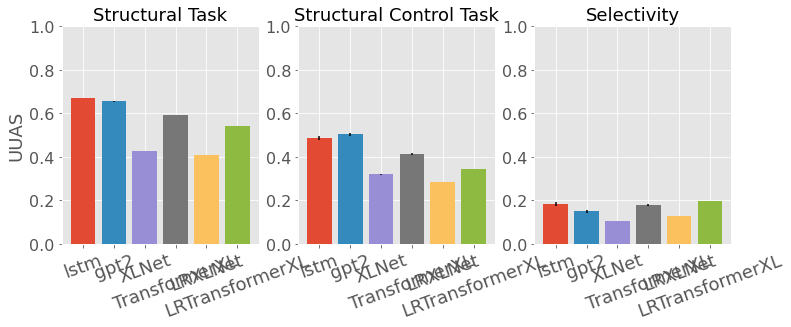

In [119]:
def find_best_dev_given_task_and_model(task, model):
    """Used to find the best hyperparams on the validation set."""
    dim = [0,256] if 'pos' in task else [16,64,128]
    controltask = 'control' + task
    best_dev_acc = 0
    best_dev_selec = 0 
    for hidden_size in dim:
        for dropout in [0,0.2,0.4,0.6,0.8]:
            dev_acc = mean_dev_acc(result_dict[task][model][hidden_size][dropout])[0]
            dev_ctrl = mean_dev_acc(result_dict[controltask][model][hidden_size][dropout])[0]
            dev_selec = dev_acc - dev_ctrl
            if dev_selec > best_dev_selec:
                best_hidden_selec = hidden_size
                best_dropout_selec = dropout
                best_dev_acc_selec = dev_acc
            if dev_acc > best_dev_acc:
                best_hidden = hidden_size
                best_dropout = dropout
                best_dev_acc = dev_acc
    return best_hidden, best_dropout, best_hidden_selec, best_dropout_selec

plt.style.use('ggplot')
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))
print_table = False

for model in ['lstm', 'transformer','XLNet', 'TransformerXL','LRXLNet', 'LRTransformerXL']:
    task = 'pos'
    model_lookup=model
    if 'LR' in model:
        the_dict = lowlr_dict
        model_lookup = model[2:]
    else:
        the_dict =result_dict
    h, d, hs, ds = find_best_dev_given_task_and_model(task, model_lookup)
    mean, sd,_ = mean_test_acc(the_dict[task][model_lookup][h][d])
    meanC, sdC,_ = mean_test_acc(the_dict['controlpos'][model_lookup][h][d])
    
    means, sds,_ = mean_test_acc(the_dict[task][model_lookup][hs][ds])
    meanCs, sdCs,_ = mean_test_acc(the_dict['controlpos'][model_lookup][hs][ds])
    if model == 'transformer': model = 'gpt2'
    print(model, task, h,d, mean, mean-meanC)
    #print('&'.join([model] + [str(round(i,2)) for i in [mean,meanC,mean-meanC, means-mean, meanCs-meanC]]), '\\\\')
    if print_table:
        print('&'.join([model.replace('ransformer','')] + [str(round(i,2)) for i in [mean,meanC,mean-meanC, means-mean, (means-meanCs)-(mean-meanC)]]), '\\\\')

    
    #print(model, task, hs,ds, means, means-meanCs)
    ax1.bar(model, mean, yerr= sd, width=0.8)#, label='model')
    ax2.bar(model, meanC, yerr=sdC,width=0.8)#, label='model')
    ax3.bar(model, mean-meanC, yerr=sd-sdC, width=0.8)#,label='model')

ax1.set_title("POS", fontsize=18)
ax2.set_title("POS Control Task", fontsize=18)
ax3.set_title("Selectivity", fontsize=18)
ax1.set_ylabel("Accuracy", fontsize=18)
for ax in [ax1,ax2,ax3]:
    ax.set_xticks([])
    ax.set_ylim(0,1)
    ax.tick_params(axis='y', labelsize=16)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))

for model in ['lstm', 'transformer','XLNet', 'TransformerXL','LRXLNet', 'LRTransformerXL']:
    task = 'dep'
    model_lookup=model
    if 'LR' in model:
        the_dict = lowlr_dict
        model_lookup = model[2:]
    else:
        the_dict =result_dict
    h, d, hs, ds = find_best_dev_given_task_and_model(task, model_lookup)
    mean, sd,_ = mean_test_acc(the_dict[task][model_lookup][h][d])
    meanC, sdC,_ = mean_test_acc(the_dict['controldep'][model_lookup][h][d])
    
    means, sds,_ = mean_test_acc(the_dict[task][model_lookup][hs][ds])
    meanCs, sdCs,_ = mean_test_acc(the_dict['controldep'][model_lookup][hs][ds])
    if model == 'transformer': model = 'gpt2'
    print(model, task, h,d, mean, mean -meanC)
    if print_table:
        print('&'.join([model.replace('ransformer','')] + [str(round(i,2)) for i in [mean,meanC,mean-meanC, means-mean, (means-meanCs)-(mean-meanC)]]), '\\\\')

    #print(model, task, hs,ds, means, means-meanCs)
    ax1.bar(model, mean, yerr= sd, width=0.8, label='model')
    ax2.bar(model, meanC, yerr=sdC, width=0.8,label='model')
    ax3.bar(model, mean-meanC, yerr=sd-sdC,width=0.8, label='model')
    
ax1.set_title("Structural Task", fontsize=18)
ax2.set_title("Structural Control Task", fontsize=18)
ax3.set_title("Selectivity", fontsize=18)
ax1.set_ylabel("UUAS", fontsize=18)
    
for ax in [ax1,ax2,ax3]:
    ax.set_ylim(0,1)
    ax.tick_params(axis='x', rotation=20, labelsize=18)
    ax.tick_params(axis='y', labelsize=16)
#plt.savefig('struct.eps', format='eps')

plt.show()

===Significance scores for POS task and control task AND SHUFFLED TASK! ===
lstm transformer shuffle 0.00866748801446317
lstm transformer perf 0.0005480845598250393
lstm transformer control 0.01276653189619603
lstm transformer select 0.0015953197520870697
lstm XLNet shuffle 0.0020961334662891917
lstm XLNet perf 9.359310329228955e-07
lstm XLNet control 4.049574552628383e-05
lstm XLNet select 0.004158870858221132
lstm TransformerXL shuffle 0.0001898014217542547
lstm TransformerXL perf 0.000390203658794862
lstm TransformerXL control 0.0007323884347119709
lstm TransformerXL select 0.0023408518578814544
transformer XLNet shuffle 0.016455674263717808
transformer XLNet perf 1.951060881502398e-06
transformer XLNet control 1.916774822132481e-05
transformer XLNet select 0.19099697405552712
transformer TransformerXL shuffle 0.003310003255101041
transformer TransformerXL perf 8.747100358757753e-05
transformer TransformerXL control 0.00021063037462934323
transformer TransformerXL select 0.043273696

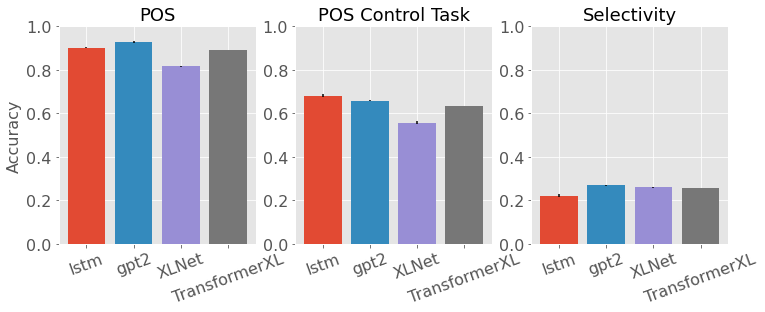

In [123]:
"""Calculates everything with respect to the shuffled task.
Helaas no control task for shuffled."""
from scipy import stats
def find_best_dev_given_task_and_model(task, model, the_dict=result_dict):
    dim = [0,256] if 'pos' in task else [16,64,128]
    best_dev_acc = 0
    for hidden_size in dim:
        for dropout in [0,0.2,0.4,0.6,0.8]:
            dev_acc = mean_dev_acc(the_dict[task][model][hidden_size][dropout])[0]
            if dev_acc > best_dev_acc:
                best_hidden = hidden_size
                best_dropout = dropout
                best_dev_acc = dev_acc
    return best_hidden, best_dropout

plt.style.use('ggplot')
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))

diffs = {'lstm':[], 'transformer':[],'XLNet':[], 'TransformerXL':[]}

perfs = {'lstm':[], 'transformer':[],'XLNet':[], 'TransformerXL':[]}

controls = {'lstm':[], 'transformer':[],'XLNet':[], 'TransformerXL':[]}

selects = {'lstm':[], 'transformer':[],'XLNet':[], 'TransformerXL':[]}

for model in ['lstm', 'transformer','XLNet', 'TransformerXL']:
    task = 'pos'
    h, d = find_best_dev_given_task_and_model(task, model)
    mean, sd, group1 = mean_test_acc(result_dict[task][model][h][d])
    
    #print("Going now")
    h2, d2 = find_best_dev_given_task_and_model(task, model, the_dict=shuffled_dict)
    meanShuffle, sdShuffle, group2 = mean_test_acc(shuffled_dict[task][model][h2][d2])
    #print(group1,group2)
    #print(model,meanShuffle-mean, stats.ttest_ind(group1,group2,equal_var=False))
    diffs[model] = (np.array(group2)-np.array(group1))
    perfs[model] = group1
    
    meanC, sdC, control = mean_test_acc(result_dict['controlpos'][model][h][d])
    controls[model] = control
    selects[model] = np.array(group1) - np.array(control)
    if model == 'transformer': model = 'gpt2'
    
    ax1.bar(model, mean, yerr= sd, width=0.8, label='model')
    ax2.bar(model, meanC, yerr=sdC,width=0.8, label='model')
    ax3.bar(model, mean-meanC, yerr=sd-sdC, width=0.8,label='model')
print("===Significance scores for POS task and control task AND SHUFFLED TASK! ===")
for m1, model in enumerate(['lstm', 'transformer','XLNet', 'TransformerXL']):
    for m2, model2 in enumerate(['lstm', 'transformer','XLNet', 'TransformerXL']):
        if m2 > m1:
            #print(diffs[model])
            #print(diffs[model2])
            print(model, model2, 'shuffle', stats.ttest_ind(diffs[model], diffs[model2]).pvalue)
            print(model, model2, 'perf', stats.ttest_ind(perfs[model], perfs[model2]).pvalue)
            print(model, model2, 'control', stats.ttest_ind(controls[model], controls[model2]).pvalue)
            print(model, model2, 'select', stats.ttest_ind(selects[model], selects[model2]).pvalue)
            
ax1.set_title("POS", fontsize=18)
ax2.set_title("POS Control Task", fontsize=18)
ax3.set_title("Selectivity", fontsize=18)
ax1.set_ylabel("Accuracy", fontsize=16)
for ax in [ax1,ax2,ax3]:
    ax.set_ylim(0,1)
    ax.tick_params(axis='x', rotation=20, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

plt.show()

Best params lstm dep 64 0
Best params transformer dep 64 0
Best params XLNet dep 64 0
Best params TransformerXL dep 64 0
===Statistical results for DEP task and DEP CONTROL task===
lstm transformer perf 5.641672599217469e-05
lstm transformer control 0.11467275313234677
lstm transformer select 0.014519988372619788
lstm XLNet perf 1.0611248893566564e-09
lstm XLNet control 2.44623914094947e-05
lstm XLNet select 0.00031267241261303137
lstm TransformerXL perf 2.909833122366578e-07
lstm TransformerXL control 0.0008322006409428964
lstm TransformerXL select 0.5401807070023817
transformer XLNet perf 4.0289733967985776e-11
transformer XLNet control 2.879329217794521e-06
transformer XLNet select 0.0010215495845939061
transformer TransformerXL perf 2.0361767853438574e-07
transformer TransformerXL control 9.651103767238291e-05
transformer TransformerXL select 0.0106850998175945
XLNet TransformerXL perf 3.365278909159593e-09
XLNet TransformerXL control 1.0829765369919466e-05
XLNet TransformerXL sele

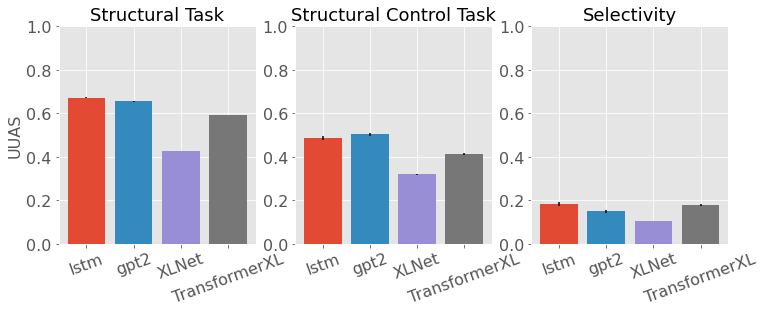

In [126]:

perfs = {'lstm':[], 'transformer':[],'XLNet':[], 'TransformerXL':[]}

controls = {'lstm':[], 'transformer':[],'XLNet':[], 'TransformerXL':[]}

selects = {'lstm':[], 'transformer':[],'XLNet':[], 'TransformerXL':[]}

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))

for model in ['lstm', 'transformer','XLNet', 'TransformerXL']:
    task = 'dep'
    h, d = find_best_dev_given_task_and_model(task, model)
    print("Best params", model, task, h,d)
    mean, sd, group1 = mean_test_acc(result_dict[task][model][h][d])
    meanC, sdC, group2 = mean_test_acc(result_dict['controldep'][model][h][d])
    perfs[model] = group1
    controls[model] = group2
    selects[model] = np.array(group1) - np.array(group2)
    if model == 'transformer': model = 'gpt2'
    
    ax1.bar(model, mean, yerr= sd, width=0.8, label='model')
    ax2.bar(model, meanC, yerr=sdC, width=0.8,label='model')
    ax3.bar(model, mean-meanC, yerr=sd-sdC,width=0.8, label='model')
print("===Statistical results for DEP task and DEP CONTROL task===")
for m1, model in enumerate(['lstm', 'transformer','XLNet', 'TransformerXL']):
    for m2, model2 in enumerate(['lstm', 'transformer','XLNet', 'TransformerXL']):
        if m2 > m1:
            #print(diffs[model])
            #print(diffs[model2])
            #print(model, model2, stats.ttest_ind(diffs[model], diffs[model2]).pvalue)
            print(model, model2, 'perf', stats.ttest_ind(perfs[model], perfs[model2]).pvalue)
            print(model, model2, 'control', stats.ttest_ind(controls[model], controls[model2]).pvalue)
            print(model, model2, 'select', stats.ttest_ind(selects[model], selects[model2]).pvalue)
            
ax1.set_title("Structural Task", fontsize=18)
ax2.set_title("Structural Control Task", fontsize=18)
ax3.set_title("Selectivity", fontsize=18)
ax1.set_ylabel("UUAS", fontsize=16)
    
for ax in [ax1,ax2,ax3]:
    ax.set_ylim(0,1)
    ax.tick_params(axis='x', rotation=20, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
plt.savefig('struct.eps', format='eps')
#plt.show()

In [127]:
raise ValueError("This is  the end of the good results")

ValueError: This is  the end of the good results

In [52]:
def acc_per_position(model, test_loader, list_of_positions, list_of_lengths):
    position_amount_dict = defaultdict(lambda:0)
    position_correct_dict = defaultdict(lambda:0)
    result = dict()
    model.eval()
    with torch.no_grad():
        i = 0 
        current_sent = 0
        current_position = 0
        for x, y in test_loader: 
            x = x.to(device)
            y = y.to(device)
            position = list_of_positions[i]
            i += 1
            current_position += 1
            output = model(x)
            pred = torch.argmax(output,dim=1)
            correct = torch.eq(pred, y)
            current_len = list_of_lengths[current_sent]
            #print(current_position, current_len, position/current_len, r)
            relative_position = round(position/current_len, 1)
            if correct.item():
                position_correct_dict[relative_position] += 1
            position_amount_dict[relative_position] += 1
            
            
            if current_position == current_len:
                #print("NEW SENT", current_sent, list_of_lengths[current_sent])
                current_sent += 1
                current_position = 0
                
            
            
    for k in sorted(list(position_amount_dict.keys())):
        result[k] = position_correct_dict[k]/position_amount_dict[k]
    #print([z for z in sorted(result.items())])
    return result, position_amount_dict


def relative_position_averaged_per_seed(model, test_loader, list_of_positions, list_of_lengths):
    """Collects uuas score per sentence length in a dict and averaged over three seeds"""
    result = defaultdict(lambda:0)
    seeds = 0
    for seed in model:
        #print(model[seed]['state_dict'])
        seeds +=1
        specific_results,_ = acc_per_position(model[seed]['state_dict'], test_loader, list_of_positions, list_of_lengths)
        for k in specific_results:
            result[k] += specific_results[k]
            
    for k in result:
        result[k] /= seeds
    return result,

In [53]:
from utils import create_or_load_pos_data
from datasets import POSDataset
from POSProbe import POSProbe

with open('results_pos.pickle', 'rb') as f:
    lstm_dict = pickle.load(f)

gpt2pos = create_or_load_pos_data("test", None, None, extra_transformer='GPT2')
lstmpos = create_or_load_pos_data("test", None, None, extra_transformer='RNN')
xlnetpos = create_or_load_pos_data("test", None, None, extra_transformer='XLNet')
transformerxlpos = create_or_load_pos_data("test", None, None, extra_transformer='TransformerXL')

gptloader = data.DataLoader(POSDataset(gpt2pos[0], gpt2pos[1]), batch_size=1)
lstmloader = data.DataLoader(POSDataset(lstmpos[0], lstmpos[1]), batch_size=1)

list_of_positions = []
list_of_lengths = []
for i in test_loader_lstm:
    length = i[2].item()
    list_of_lengths.append(length)
    for z in range(length):
        list_of_positions.append(z)

accsLSTM = relative_position_averaged_per_seed( lstm_dict['pos']['lstm'][256][0.2], lstmloader, list_of_positions, list_of_lengths)
accsGPT  = relative_position_averaged_per_seed(lstm_dict['pos']['transformer'][256][0.2], gptloader, list_of_positions, list_of_lengths)
#accsGPT, amounts = acc_per_position(lstm_dict['pos']['transformer'][256][0.2], gptloader, list_of_positions, list_of_lengths)
#accsGPT, amounts = acc_per_position(lstm_dict['pos']['transformer'][256][0.2], gptloader, list_of_positions, list_of_lengths)

#accsXLNET, _ = acc_per_position(lstm_dict['pos']['lstm'][256][0.2][10]['state_dict'], lstmloader, list_of_positions)
#accsTXL, _ = acc_per_position(lstm_dict['pos']['transformer'][256][0.2][10]['state_dict'], gptloader, list_of_positions)



USING SAVE corpus/transformer_postest.pickle
USING SAVE corpus/RNN_postest.pickle
USING SAVE corpus/transformer_postest_XLNet.pickle
USING SAVE corpus/transformer_postest_TransformerXL.pickle


In [54]:
xlnetloader = data.DataLoader(POSDataset(xlnetpos[0], lstmpos[1]), batch_size=1)
txlloader = data.DataLoader(POSDataset(transformerxlpos[0], lstmpos[1]), batch_size=1)
print(xlnetpos[0].shape, xlnetpos[1])

accsXLNET = relative_position_averaged_per_seed(result_dict['pos']['XLNet'][256][0.2], xlnetloader, list_of_positions, list_of_lengths)
accsTXL = relative_position_averaged_per_seed(result_dict['pos']['TransformerXL'][256][0.2], txlloader, list_of_positions , list_of_lengths)

torch.Size([25096, 1024]) 0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


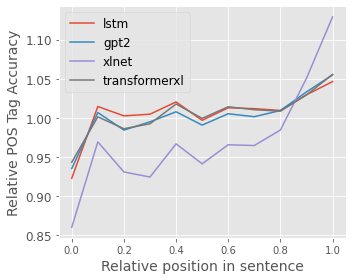

In [62]:
"""Failed test for relative sentence position. """
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig, ax1 = plt.subplots(1,1, figsize=(5,4))
accsLSTM2 = {}
accsGPT2 = {}
accsXLNET2 = {}
accsTXL2 = {}

for z in accsLSTM[0]:
    accsLSTM2[z] = accsLSTM[0][z]/0.9
    
for z in accsGPT[0]:
    accsGPT2[z] = accsGPT[0][z]/0.93

for z in accsXLNET[0]:
    accsXLNET2[z] = accsXLNET[0][z]/0.83
    
for z in accsTXL[0]:
    accsTXL2[z] = accsTXL[0][z]/0.89
    
ax1.plot(*zip(*accsLSTM2.items()), label='lstm')
ax1.plot(*zip(*accsGPT2.items()), label='gpt2')
ax1.plot(*zip(*accsXLNET2.items()), label='xlnet')
ax1.plot(*zip(*accsTXL2.items()), label='transformerxl')


    
#ax2.plot(*zip(*accsLSTM[0].items()), label='lstm')
#ax2.plot(*zip(*accsGPT[0].items()), label='gpt2')
#ax2.plot(*zip(*accsXLNET[0].items()), label='xlnet')
#ax2.plot(*zip(*accsTXL[0].items()), label='transformerxl')

#ax2.plot(*zip(*amounts.items()))
#ax1.plot(*zip(*xlnet.items()), label='XLNet')
#ax1.plot(*zip(*txl.items()), label='TransformerXL')
#ax1.plot(*zip(*lrxlnet.items()), label='XLNetLR')
#ax1.plot(*zip(*lrtransformerxl.items()), label='TransformerXLLR')

#ax2.plot(*zip(*ngpt2.items()), label='gpt2')
#ax2.plot(*zip(*nrnn.items()), label='lstm')
#ax2.plot(*zip(*nxlnet.items()), label='xlnet')
ax1.tick_params(axis='y', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)

ax1.legend(fontsize=12,)
ax1.set_xlabel("Relative position in sentence",fontsize=14)
ax1.set_ylabel("Relative POS Tag Accuracy", fontsize=14)
plt.savefig('sentences.eps', format='eps',  dpi=1200,   bbox_inches='tight')
plt.tight_layout()
plt.show()


In [87]:
"""Failed test for shuffled sentences."""
# data.DataLoader(StructuralDataset(*gpt2embs), batch_size=1, shuffle=False)
from datasets import POSDataset
gpt2Shuffle = data.DataLoader(
    POSDataset(*create_or_load_pos_data("test", None, None, extra_transformer='GPT2', shuffled=True)[0:2]), 
               batch_size=1, shuffle=False)
lstmShuffle = data.DataLoader(
    POSDataset(*create_or_load_pos_data("test", None, None, extra_transformer='RNN', shuffled=True)[0:2]), 
               batch_size=1, shuffle=False)
xlnetShuffle = data.DataLoader(
    POSDataset(*create_or_load_pos_data("test", None, None, extra_transformer='XLNet', shuffled=True)[0:2]), 
               batch_size=1, shuffle=False)
transformerxlShuffle = data.DataLoader(
    POSDataset(*create_or_load_pos_data("test", None, None, extra_transformer='TransformerXL', shuffled=True)[0:2]),
               batch_size=1, shuffle=False)


gpt2Data = data.DataLoader(
    POSDataset(*create_or_load_pos_data("test", None, None, extra_transformer='GPT2', shuffled=False)[0:2]),
               batch_size=1, shuffle=False)
lstmData = data.DataLoader(
    POSDataset(*create_or_load_pos_data("test", None, None, extra_transformer='RNN', shuffled=False)[0:2]),
               batch_size=1, shuffle=False)
xlnetData = data.DataLoader(
    POSDataset(*create_or_load_pos_data("test", None, None, extra_transformer='XLNet', shuffled=False)[0:2]),
               batch_size=1, shuffle=False)
transformerxlData = data.DataLoader(
    POSDataset(*create_or_load_pos_data("test", None, None, extra_transformer='TransformerXL', shuffled=False)[0:2]),
               batch_size=1, shuffle=False)

USING SAVE corpus/transformer_postest_shuffled.pickle
USING SAVE corpus/RNN_postest_shuffled.pickle
USING SAVE corpus/transformer_postest_XLNet_shuffled.pickle
USING SAVE corpus/transformer_postest_TransformerXL_shuffled.pickle
USING SAVE corpus/transformer_postest.pickle
USING SAVE corpus/RNN_postest.pickle
USING SAVE corpus/transformer_postest_XLNet.pickle
USING SAVE corpus/transformer_postest_TransformerXL.pickle


In [92]:
with open('results_pos.pickle', 'rb') as f:
    lstm_dict = pickle.load(f)
lstm = lstm_dict['pos']['lstm'][256][0.2]
lstmS = shuffled_dict['pos']['lstm'][256][0]
gpt2 = lstm_dict['pos']['transformer'][256][0.2]
gpt2S = shuffled_dict['pos']['transformer'][256][0]
xlnet = result_dict['pos']['XLNet'][256][0.2]
xlnetS = shuffled_dict['pos']['XLNet'][256][0]
txl = result_dict['pos']['TransformerXL'][256][0.2]
txlS = shuffled_dict['pos']['TransformerXL'][256][0]